In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

# Открою датасет
data = pd.read_csv('qs-world-university-rankings-2017-to-2022-V2.csv', sep=",")
# характеристики
print("размер:", data.shape)
print("\nколонки:\n", data.dtypes)


размер: (6482, 15)

колонки:
 university                 object
year                        int64
rank_display               object
score                     float64
link                       object
country                    object
city                       object
region                     object
logo                       object
type                       object
research_output            object
student_faculty_ratio     float64
international_students     object
size                       object
faculty_count              object
dtype: object


In [2]:
print("\nПропущенные значения, %:")
for index, value in data.isnull().sum().get(lambda x: x > 0).items():
  # print("%s:\t\t%d\t\t%.3f%%" % (index, value, value*100/data.shape[0]))
  print("{:25s} {: ^10} {:>10.3f}%\t{:s}".format(index, value, value*100/data.shape[0], str(data[index].dtype)))


Пропущенные значения, %:
rank_display                  68          1.049%	object
score                        3662        56.495%	float64
city                         178          2.746%	object
type                          12          0.185%	object
research_output               2           0.031%	object
student_faculty_ratio         75          1.157%	float64
international_students       164          2.530%	object
size                          2           0.031%	object
faculty_count                 78          1.203%	object


Колонки, где больше 10% пропусков следует **удалить**, чтобы **не портить** модель, но это относится к категориальным признакам. У меня таких нет.

Очистка колонки score могла бы быть сделана следующим образом:

In [3]:
data_no_score = data.dropna(subset=["score"])
print("Очистка от строк, где score = 0:")
print("Было %d значений. Стало %d. Было удалено %d." % (data_no_score.shape[0], data_no_score.shape[0], data.shape[0] - data_no_score.shape[0]))
(data.shape, data_no_score.shape)

Очистка от строк, где score = 0:
Было 2820 значений. Стало 2820. Было удалено 3662.


((6482, 15), (2820, 15))

Выведу гистограммы числовых признаков с пропусками:

score (пропущено 56.495%):


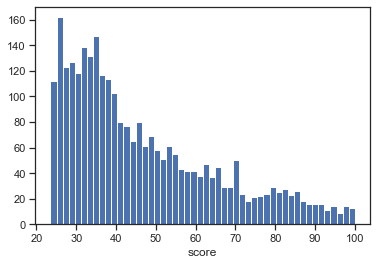

student_faculty_ratio (пропущено 1.157%):


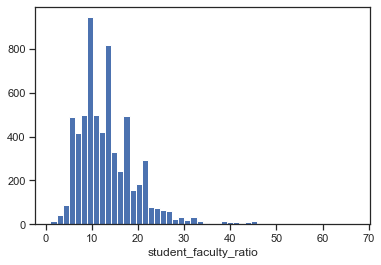

Числовые признаки с пропусками: ['score', 'student_faculty_ratio']


In [4]:
num_missing_cols_list = []

for index, value in data.isnull().sum().get(lambda x: x > 0).items():
  if (str(data[index].dtype) == "float64" or str(data[index].dtype) == "int64"):
    num_missing_cols_list.append(index)
    print(index, "(пропущено %2.3f%%):" % (value/data[index].shape[0] * 100))
    plt.hist(data[index], 50)
    plt.xlabel(index)
    plt.show()

print("Числовые признаки с пропусками:", num_missing_cols_list)

Видно, что student_faculty_ratio содержит пропуски на участках 34-39. Восполню пропуски используя стратегию с медианным значением.

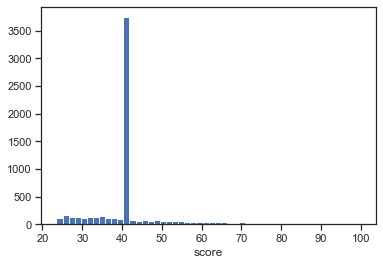

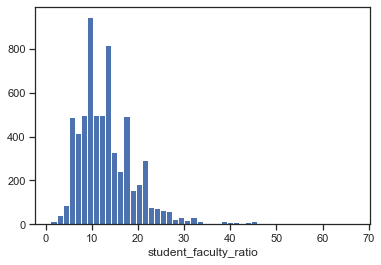

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

SkSI = SimpleImputer(strategy="median")

for value in num_missing_cols_list:
  plt.hist(SkSI.fit_transform(data[[value]]), 50)
  plt.xlabel(value)
  plt.show()


Видно, что вторая гистограмма не изменила свой вид, что можно считать успехом. Но Заполнение 3500+ пропусков в первой таблице одинаковыми значениями приводит к аномалии.
Конечно, я попробовал все стратегии заполнения, которые предлагает SkLearn Imputer. Тут нужны иные, вставляющие такие значения, что они распределяются равномерно.

Вообще-то, **score** - это **целевой** признак, и нулевое значение для него адекватно, с той лишь поправкой, что в данном датасете оценок ниже 25 - только 0.

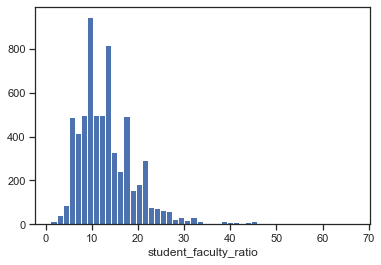

In [6]:
for value in num_missing_cols_list:
  if value == "score":
    continue
  data[value] = SkSI.fit_transform(data[[value]])
  plt.hist(data[value], 50)
  plt.xlabel(value)
  plt.show()

In [7]:
for index, value in data.isnull().sum().get(lambda x: x > 0).items():
  if (str(data[index].dtype) == "float64" or str(data[index].dtype) == "int64"):
    print(index, "(пропущено %2.3f%%):" % (value/data[index].shape[0] * 100))

score (пропущено 56.495%):


Теперь для категориальных признаков:

In [8]:
cat_missing_cols_list = []
print("Категориальные признаки с пропусками")
print("|       Признак        |        пропущено         | число уникальных |")

for index, value in data.isnull().sum().get(lambda x: x > 0).items():
  if (str(data[index].dtype) == "object"):
    cat_missing_cols_list.append(index)
    print("{:25s} {: <10} {:>10.3f}%\t{:>5d}".format(index, value, value*100/data.shape[0], len(data[index].unique())))


Категориальные признаки с пропусками
|       Признак        |        пропущено         | число уникальных |
rank_display              68              1.049%	  518
city                      178             2.746%	  867
type                      12              0.185%	    3
research_output           2               0.031%	    6
international_students    164             2.530%	 1183
size                      2               0.031%	    5
faculty_count             78              1.203%	 1177


По таблице видно, что колонки "тип", "размер" и "результат исследования" содержат 2, 4 и 5 значений. Еще одно значение это NAN, от которого следует избавиться.

In [9]:
print(data['type'].unique())
print(data['research_output'].unique())
print(data['size'].unique())


['Private' 'Public' nan]
['Very High' 'Very high' 'High' 'Medium' 'Low' nan]
['M' 'L' 'S' 'XL' nan]


Логично заполнить размер университета наиболее частым значением, а вот текстовая оценка должна напрямую коррелировать со значением в колонке score. Обычно, такие признаки удаляют. Значение типа целесообразно заполнить константой public, т.е. по умолчанию, считать университет доступным для всех. 

In [10]:
# Импьютация константой
cat_type_imptr = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Public')
data["type"] = cat_type_imptr.fit_transform(data[["type"]])
print(data['type'].unique())

['Private' 'Public']


In [11]:
# Импьютация наиболее частыми значениями
cat_type_imptr = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data["size"] = cat_type_imptr.fit_transform(data[["size"]])
print(data['size'].unique())

['M' 'L' 'S' 'XL']


С текстовой оценкой сложнее. Для начала заменю Very high на Very High, т.к. оценка идентичная:

In [12]:
print(data['research_output'].unique())
data.loc[data['research_output'] == 'Very high', 'research_output'] = "Very High"
print(data['research_output'].unique())

['Very High' 'Very high' 'High' 'Medium' 'Low' nan]
['Very High' 'High' 'Medium' 'Low' nan]


Теперь нужно узнать, какое значение **score** считается нижней оценкой для каждой категории из списка выше, а какое верхней:

In [13]:
print('Категория | минимальное | максимальное')
for category in data['research_output'].unique():
  this_category_row = data[data['research_output'] == category]
  print("{:<15}{:<9.1f}{:10.1f}".format(category, this_category_row['score'].min(), this_category_row['score'].max()))

Категория | минимальное | максимальное
Very High      23.5          100.0
High           23.6           73.6
Medium         23.5           36.0
Low            24.3           25.2
nan            nan             nan


Оказывается, те строки, в которых **пропущены score**, так же не имеют словесной оценки, значит, все же строки с пропущенным score можно **удалить**, т.к. по ним никак **нельзя** обучить модель предсказывать оценку по остальным параметрам. А заполнить все константами Low - значит испортить модель.

Хоть минимальная оценка для каждой категории примерно 23.5, категорию можно определеть по максимальной оценке, однако прямой корреляции между признаками нет, а значит, категориальная оценка все еще имеет смысл для анализа.

Сначала удалю те строки, в которых и **score = NAN**, и **research_output = NAN**, а в оставшихся строках заменю **score = NAN** на **score = 0**:

In [14]:
data_no_score = data.dropna(subset=["score", "research_output"], how='all')
print("Очистка от строк, где score = 0:")
print("Было %d значений. Стало %d. Было удалено %d (%2.3f%%)." % (data.shape[0], data_no_score.shape[0], data.shape[0] - data_no_score.shape[0], (data.shape[0] - data_no_score.shape[0])/data.shape[0]*100))


Очистка от строк, где score = 0:
Было 6482 значений. Стало 6480. Было удалено 2 (0.031%).


C:\Users\dturc\AppData\Local\Temp\ipykernel_23040\3819309333.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_score["score"] = num_score_imptr.fit_transform(data_no_score[["score"]])


Категория | минимальное | максимальное
Very High      0.0           100.0
High           0.0            73.6
Medium         0.0            36.0
Low            0.0            25.2


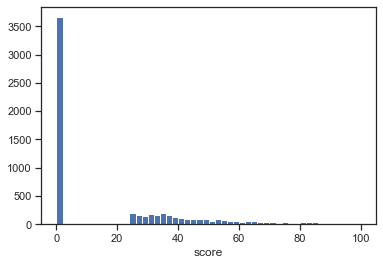

In [15]:
num_score_imptr = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
data_no_score["score"] = num_score_imptr.fit_transform(data_no_score[["score"]])

print('Категория | минимальное | максимальное')
for category in data_no_score['research_output'].unique():
  this_category_row = data_no_score[data_no_score['research_output'] == category]
  print("{:<15}{:<9.1f}{:10.1f}".format(category, this_category_row['score'].min(), this_category_row['score'].max()))

plt.hist(data_no_score["score"], 50)
plt.xlabel("score")
plt.show()

Как видно, заполнение нулями, как и иными константами, как я говорил выше, не имеет никакого смысла. Более того, еще и портит минимальные значения для другого признака. в котором мало пропусков. **Удалю строки, где score = 0**. Пропуски по полю **research_output** пропадут, что следуюет из исследования выше.

In [16]:
data_no_score = data.dropna(subset=["score"])
print("Очистка от строк, где score = 0:")
print("Было %d значений. Стало %d. Было удалено %d (%2.3f%%)." % (data.shape[0], data_no_score.shape[0], data.shape[0] - data_no_score.shape[0], (data.shape[0] - data_no_score.shape[0])/data.shape[0]*100))
data = data_no_score

print('Категория | минимальное | максимальное')
for category in data['research_output'].unique():
  this_category_row = data[data['research_output'] == category]
  print("{:<15}{:<9.1f}{:10.1f}".format(category, this_category_row['score'].min(), this_category_row['score'].max()))

Очистка от строк, где score = 0:
Было 6482 значений. Стало 2820. Было удалено 3662 (56.495%).
Категория | минимальное | максимальное
Very High      23.5          100.0
High           23.6           73.6
Medium         23.5           36.0
Low            24.3           25.2


Остальные категориальные признаки заполню наиболее часто встречающейся категорией:

In [17]:
cat_missing_cols_list.remove("research_output")
cat_missing_cols_list.remove("type")
cat_missing_cols_list.remove("size")

In [18]:
cat_imptr = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for category in cat_missing_cols_list:
  data[category] = cat_imptr.fit_transform(data[[category]])

print("Категориальные признаки с после заполнения пропусков")
print("|       Признак        |        пропущено         | число уникальных |")

for index, value in data.isnull().sum().get(lambda x: x > 0).items():
  if (str(data[index].dtype) == "object"):
    print("{:25s} {: <10} {:>10.3f}%\t{:>5d}".format(index, value, value*100/data.shape[0], len(data[index].unique())))

Категориальные признаки с после заполнения пропусков
|       Признак        |        пропущено         | число уникальных |


Видно, что пропусков в категориальных значениях больше нет.

Теперь нормализую строковые признаки.

In [19]:
cat_cols = []

print("Категория | число уникальных")
for index in data:
  if (str(data[index].dtype) == "object"):
    cat_cols.append(index)
    print("{:20}\t{:4d}".format(index, len(data[index].unique())))

print('Строковые признаки:', cat_cols)

Категория | число уникальных
university          	 564
rank_display        	 492
link                	 561
country             	  62
city                	 407
region              	   6
logo                	 565
type                	   2
research_output     	   4
international_students	 535
size                	   4
faculty_count       	 529
Строковые признаки: ['university', 'rank_display', 'link', 'country', 'city', 'region', 'logo', 'type', 'research_output', 'international_students', 'size', 'faculty_count']


Оказывается, international_students, rank_display	и faculty_count - на самом деле числовые признаки, причем rank_display вообще не имеет смысла для анализа, т.к. задает место университета в обшем зачете:

In [20]:
print(data["international_students"].head())
print(data["faculty_count"].head())
print(data["rank_display"].head())
print(data["rank_display"].tail())


0    3,730
1    3,879
2    5,877
3    7,925
4      692
Name: international_students, dtype: object
0    3,065
1    4,725
2    4,646
3    5,800
4      968
Name: faculty_count, dtype: object
0    1
1    2
2    3
3    4
4    5
Name: rank_display, dtype: object
5678    494
5679    494
5680    494
5681    494
5682    494
Name: rank_display, dtype: object


Заменю псевдостроки на числа. Помню, что стратегия восстановления пропусков была most frequent, что в принципе не важно, т.к. пропусков довольно мало 

In [21]:
pseudo_categorial_list = ['international_students', 'faculty_count', 'rank_display']
for category in pseudo_categorial_list:
  cat_cols.remove(category)

In [22]:
for category in pseudo_categorial_list:
  data[category] = pd.to_numeric(data[category].str.replace('\D', ''))

print('\n', data.dtypes)


 university                 object
year                        int64
rank_display                int64
score                     float64
link                       object
country                    object
city                       object
region                     object
logo                       object
type                       object
research_output            object
student_faculty_ratio     float64
international_students      int64
size                       object
faculty_count               int64
dtype: object


C:\Users\dturc\AppData\Local\Temp\ipykernel_23040\1339140512.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data[category] = pd.to_numeric(data[category].str.replace('\D', ''))


Уникальные строковые признаки: 

In [23]:
print("Категория | число уникальных | всего", data.shape[0])
for index in data:
  if (str(data[index].dtype) == "object"):
    print("{:20}\t{:4d}".format(index, len(data[index].unique())))

print('Строковые признаки:', cat_cols)

Категория | число уникальных | всего 2820
university          	 564
link                	 561
country             	  62
city                	 407
region              	   6
logo                	 565
type                	   2
research_output     	   4
size                	   4
Строковые признаки: ['university', 'link', 'country', 'city', 'region', 'logo', 'type', 'research_output', 'size']


Уникальные числовые признаки: 

In [24]:
print("Категория | число уникальных | всего", data.shape[0])
for index in data:
  if (str(data[index].dtype) == "float64" or str(data[index].dtype) == "int64"):
    print("{:20}\t{:4d}".format(index, len(data[index].unique())))

Категория | число уникальных | всего 2820
year                	   6
rank_display        	 492
score               	 656
student_faculty_ratio	  32
international_students	 527
faculty_count       	 512


Удалю бессмысленные категориальные признаки: логотип и ссылки, связанные напрямую с университетом. Также ясно, что город, страна, регион коррелируют между собой, но могут быть полезны в дальнейших исследованиях.
Удалю бессмысленные числовые признаки: rank_display:

In [34]:
data = data.drop(columns=["logo", 'link', 'rank_display'])

In [35]:
print(data.dtypes)
print(data.shape)

university                 object
year                        int64
score                     float64
country                    object
city                       object
region                     object
type                       object
research_output            object
student_faculty_ratio     float64
international_students      int64
size                       object
faculty_count               int64
dtype: object
(2820, 12)


Сохраню в таблицу очищенный датасет. Он пригодится в дальнейших работах.

In [36]:
data.to_csv('university-rankings-cleared.csv', index=False)

In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data = le.fit_transform(dat['c1'])

NameError: name 'dat' is not defined